# Data-reuploading (simulator)

Main steps:

* initialize an image of the sky (frequency domain)
* apply 2D FT --> visibilities (Fourier domain)
* encode visibilities data onto a single qubit using data-reuploading for the source-finding problem (non-conventional domain)
* training + testing phases

Data-reuploading:

* [paper](https://arxiv.org/abs/1907.02085)
* [PennyLane documentation](https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier.html)
* [tutorial](https://github.com/NLESC-quantum/quantum_comp/blob/main/pulsar_search/ml/reupload/tutorial_data_reuploading_classifier.ipynb)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

## 1) Generating an artificial image of the sky (frequency domain)

In [2]:
#image of the sky filled with double precision complex floats ('complex64')
#pixels are set to low complex random values (image background/noise) 
#few pixels are set to larger complex random values in a specified ellipse area (image source/subject)
n = 10 #20
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(3, 11)
radius = np.random.randint(1, 3)

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[-1.39007866e-02-1.4056873e-02j -2.52042967e-03-5.8649452e-03j
  -1.07495263e-02-2.2875983e-03j -1.51889808e-02+8.1646089e-03j
   8.88956990e-03+5.2100988e-03j -5.43225044e-03-2.0594308e-03j
  -8.92363489e-03+4.4837389e-03j  6.78306352e-03-3.8949321e-03j
   1.48276752e-02+6.9471211e-03j  1.17477207e-02+4.0924549e-03j]
 [ 5.18598862e+01+5.4083229e+01j -2.60457140e-03-2.0570334e-02j
   9.70048888e-04-3.5170957e-03j  1.14045525e-02+6.5402291e-03j
  -4.67568776e-03+8.3964097e-04j  1.51781151e-02-9.7487802e-03j
   3.36505403e-03+8.7484568e-03j -6.90808473e-03+1.3444545e-03j
   4.58371315e+01+3.9906521e+01j -8.27468559e-03+3.9258057e-06j]
 [ 4.53263242e-03-2.5679823e-03j -1.08058313e-02+1.4629643e-02j
   2.43316335e-03+8.2822591e-03j  1.78762048e-03-2.9369630e-02j
  -9.77590866e-03+6.1124703e-03j -2.45293207e-03+1.2455495e-02j
   1.33855091e-02-1.7389989e-02j -2.57388782e-03+8.7039797e-03j
   1.32587962e-02-1.2117226e-03j  2.08694092e-03-2.4572946e-03j]
 [ 1.14558237e-02-3.1491611e-03j  9.0

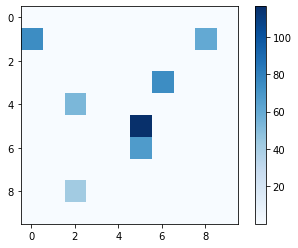

In [3]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 2) Applying a 2D FT (Fourier domain)

In [4]:
visibilities = np.fft.fft2(sky_image).astype('complex64')
print(visibilities)

[[ 335.11246  +338.8085j     -75.384285  -37.69165j
   168.8279    +35.127598j  -183.93771   -95.11939j
   134.24843  +160.14731j     95.81573   +77.07986j
   163.93584  +224.1482j     -70.63284  -227.12161j
    55.68761  +166.87881j   -105.13021  -101.942924j ]
 [ -42.705822 -184.68138j    233.92854  +273.37305j
  -179.03516   -51.519657j   300.75916   +66.13191j
   -96.24927  -141.14206j    260.93552   +23.332642j
   -69.51486   +65.396614j   124.4998   +156.61148j
    -2.812455 -141.91974j    207.40302   +66.96931j  ]
 [ 146.21426   +33.281162j    10.44936   -40.96497j
   255.24872  +176.03557j   -151.5042   -224.84688j
   238.77113   -42.949596j  -177.61844   -93.50204j
   334.1806    +85.31471j    -68.47733   +49.44274j
   172.39368   -98.08497j    -85.13635  -169.73022j  ]
 [   2.9404151-142.79298j    134.11377  -147.5871j
  -108.04333   -23.256384j    65.17066  +126.69625j
   -63.671658 -167.83466j    295.5812    -93.68621j
  -158.341    -196.67824j    184.4783    +25.697577j
  

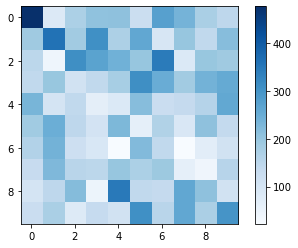

In [5]:
modulus = np.absolute(visibilities)
plt.imshow(modulus, cmap='Blues')
plt.colorbar();

## 3) Source-finding classification

### Training labels

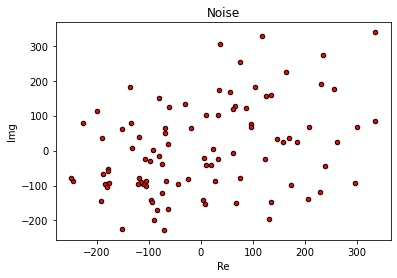

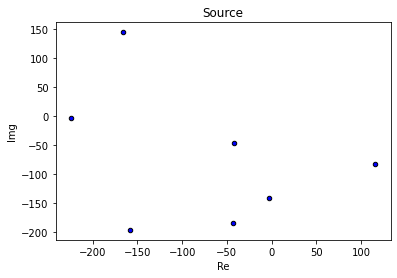

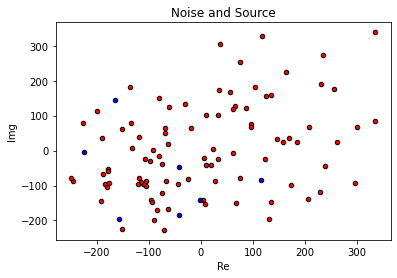

In [6]:
def labels(data, mask):
    
    Xvals, yvals = [], []
    
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] == True:
                label = 1
            else:
                label = 0
        
            yvals.append(label)
            Xvals.append((data[i][j].real, data[i][j].imag))
        
    return pnp.array(Xvals, requires_grad=False), pnp.array(yvals, requires_grad=False)


def plot_data(x, y, ax=None):
    
    reds = y == 0
    blues = y == 1
    plt.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Noise')
    plt.show()
    
    plt.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Source')
    plt.show()
    
    plt.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    plt.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    plt.gca().set_xlabel("Re")
    plt.gca().set_ylabel("Img")
    plt.title('Noise and Source')
    plt.show()
    
Xdata, ydata = labels(visibilities, mask)
plot_data(Xdata, ydata)


# Define output labels as quantum state vectors
def density_matrix(state):
    
    return state * pnp.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = pnp.array([label_0, label_1], requires_grad=False)

### Simple classifier with data reloading and fidelity loss

In [7]:
dev = qml.device("lightning.qubit", wires=1)
# Install any pennylane-plugin to run on some particular backend
# https://docs.pennylane.ai/projects/qiskit/en/latest/
# https://docs.pennylane.ai/en/stable/introduction/interfaces.html


@qml.qnode(dev)
def qcircuit(params, x, y):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x[i], dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

### Utility functions for testing and creating batches

In [8]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return pnp.array(predicted), pnp.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

### Train a quantum classifier on the visibilities

In [9]:
# Generate training and test data
X_data, y_data = labels(visibilities, mask)
indices = []
for i in range(0, len(X_data)):
    indices.append(i)
random.shuffle(indices)

for i in range(0, len(X_data)):
    X_data[i] = X_data[indices[i]]
    y_data[i] = y_data[indices[i]]

index = int(0.8*len(X_data))
X_train, y_train = X_data[:index], y_data[:index]
X_test, y_test = X_data[index:], y_data[index:]

X_train = pnp.hstack((X_train, pnp.zeros((X_train.shape[0], 1), requires_grad=False)))
X_test = pnp.hstack((X_test, pnp.zeros((X_test.shape[0], 1), requires_grad=False)))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3 #2
learning_rate = 0.6 #1e-3
epochs = 10 #25
batch_size = 32 #64

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = pnp.random.uniform(size=(num_layers, 3), requires_grad=True)

predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in tqdm(iterate_minibatches(X_train, y_train, batch_size=batch_size)):
        params, _, _, _ = opt.step(cost, params, Xbatch, ybatch, state_labels)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

0it [00:00, ?it/s]

Epoch:  0 | Cost: 0.435313 | Train accuracy: 0.612500 | Test Accuracy: 0.350000


2it [00:07,  3.90s/it]
0it [00:00, ?it/s]

Epoch:  1 | Loss: 0.232343 | Train accuracy: 0.675000 | Test accuracy: 0.500000


2it [00:08,  4.21s/it]
0it [00:00, ?it/s]

Epoch:  2 | Loss: 0.203925 | Train accuracy: 0.687500 | Test accuracy: 0.750000


2it [00:09,  4.64s/it]
0it [00:00, ?it/s]

Epoch:  3 | Loss: 0.190055 | Train accuracy: 0.762500 | Test accuracy: 0.700000


2it [00:09,  4.74s/it]
0it [00:00, ?it/s]

Epoch:  4 | Loss: 0.165593 | Train accuracy: 0.775000 | Test accuracy: 0.700000


2it [00:09,  4.66s/it]
0it [00:00, ?it/s]

Epoch:  5 | Loss: 0.130936 | Train accuracy: 0.850000 | Test accuracy: 0.900000


2it [00:09,  4.67s/it]
0it [00:00, ?it/s]

Epoch:  6 | Loss: 0.111119 | Train accuracy: 0.887500 | Test accuracy: 0.900000


2it [00:09,  4.72s/it]
0it [00:00, ?it/s]

Epoch:  7 | Loss: 0.173798 | Train accuracy: 0.787500 | Test accuracy: 0.800000


2it [00:09,  4.59s/it]
0it [00:00, ?it/s]

Epoch:  8 | Loss: 0.168550 | Train accuracy: 0.825000 | Test accuracy: 0.800000


2it [00:09,  4.68s/it]
0it [00:00, ?it/s]

Epoch:  9 | Loss: 0.140293 | Train accuracy: 0.850000 | Test accuracy: 0.850000


2it [00:09,  4.62s/it]


Epoch: 10 | Loss: 0.115814 | Train accuracy: 0.850000 | Test accuracy: 0.800000


### Results

Cost: 0.115814 | Train accuracy 0.850000 | Test Accuracy : 0.800000
Learned weights
Layer 0: [1.29839057 1.21410316 0.71728815]
Layer 1: [-1.36982237 -1.59332016  0.30517808]
Layer 2: [-1.54871743  1.52503766  0.36998065]


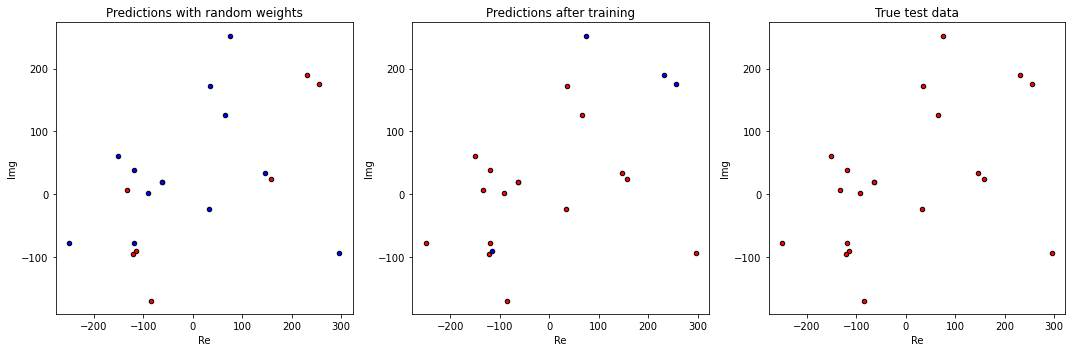

[-1 -1 -1 -1  1  0  1  0  0  0 -1  0 -1 -1 -1 -1 -1 -1  1 -1]


In [10]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))

fig, axs = plt.subplots(1, 3, figsize=(15,5))
reds = initial_predictions == 0
blues = initial_predictions == 1
axs[0].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[0].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")
reds = predicted_test == 0
blues = predicted_test == 1
axs[1].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[1].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")
reds = y_test == 0
blues = y_test == 1
axs[2].scatter(X_test[reds, 0], X_test[reds, 1], c="red", s=20, edgecolor="k")
axs[2].scatter(X_test[blues, 0], X_test[blues, 1], c="blue", s=20, edgecolor="k")

axs[0].set_title("Predictions with random weights")
axs[1].set_title("Predictions after training")
axs[2].set_title("True test data")

for ax in axs.flat:
    ax.set(xlabel='Re', ylabel='Img')

plt.tight_layout()
plt.show()

print(predicted_test - initial_predictions)